In [166]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter, median_filter

from utils import normalize, rgb2gray, compute_gradients, mse, psnr
from denoiser import DATA_PATH, bilateral_filter, guided_filter, bilateral_get_weight

import ipywidgets as widgets
from ipywidgets import interact

# Quantitative evaluation

In [ ]:
sigma_r = 0.2
sigma_s = 5
sigma_o = 0.5
guided_filter_r = 5
guided_filter_eps = 0.0007

print(f'Hyperparameters: sigma_r={sigma_r}, sigma_s={sigma_s}, sigma_o={sigma_o}, eps={eps}')

mses = dict()
psnrs = dict()
for image_id in range(12):
    print(f'Processing image {image_id}')

    clean = np.array(Image.open(f"{DATA_PATH}/original/{image_id:03d}.png"))[:, :, :3]
    noisy = np.array(Image.open(f"{DATA_PATH}/noised/{image_id:03d}.jpg"))
    clean = rgb2gray(normalize(clean))
    p = rgb2gray(normalize(noisy))

    magnitudes = compute_gradients(p, num_directions=2)
    I = bilateral_filter(p, gradient_magnitudes=magnitudes, r=4,
                        sigma_s=sigma_s, sigma_r=sigma_r, sigma_o=sigma_o)
    q = guided_filter(I=I, p=p, r=guided_filter_r, eps=guided_filter_eps)

    q_gaussian = gaussian_filter(p, sigma=0.5)
    q_median = median_filter(p, size=3)
    q_bilateral = bilateral_filter(p, gradient_magnitudes=magnitudes, r=4,
                        sigma_s=sigma_s, sigma_r=sigma_r, sigma_o=100)
    mses[image_id] = {
        'before': mse(clean, p),
        'step1': mse(clean, I),
        'step2': mse(clean, q),
        'gaussian': mse(clean, q_gaussian),
        'median': mse(clean, q_median),
        'bilateral': mse(clean, q_bilateral)
    }
    psnrs[image_id] = {
        'before': psnr(clean, p),
        'step1': psnr(clean, I),
        'step2': psnr(clean, q),
        'gaussian': psnr(clean, q_gaussian),
        'median': psnr(clean, q_median),
        'bilateral': psnr(clean, q_bilateral)
    }

In [ ]:
metrics = ['before', 'gaussian', 'median','bilateral', 'step1', 'step2']
print('MSE:')
for metric in metrics:
    mean_mse_value = np.mean([v[metric] for v in list(mses.values())])
    mean_psnr_value = 10 * np.log10(1 / mean_mse_value)
    print(f'{metric}\t MSE: {mean_mse_value:.6f}\t PSNR: {mean_psnr_value:.2f}')


MSE:
before	 MSE: 0.000902	 PSNR: 30.45
gaussian	 MSE: 0.001194	 PSNR: 29.23
median	 MSE: 0.003706	 PSNR: 24.31
bilateral	 MSE: 0.000750	 PSNR: 31.25
step1	 MSE: 0.000734	 PSNR: 31.34
step2	 MSE: 0.000716	 PSNR: 31.45


# Weights plotting for gradient-aware bilateral filtering

In [9]:
image_id = 6
original = np.array(Image.open(f"{DATA_PATH}/original/{image_id:03d}.png"))[:, :, :3]
noised = np.array(Image.open(f"{DATA_PATH}/noised/{image_id:03d}.jpg"))

original = normalize(original)
noised = normalize(noised)
print(original.shape, noised.shape)
original_gray = rgb2gray(original)
noised_gray = rgb2gray(noised)
print(original.shape, noised.shape)

p = noised_gray
H, W = p.shape
magnitudes = compute_gradients(noised_gray, num_directions=2)

(600, 600, 3) (600, 600, 3)
(600, 600, 3) (600, 600, 3)


In [24]:
def plot_weights(i, j):
    r = 4
    i_range = np.arange(max(i - r, 0), min(i + r + 1, H))
    j_range = np.arange(max(j - r, 0), min(j + r + 1, W))

    sigma_r = 0.3
    sigma_s = 5
    sigma_o = 0.5
    w_basic, w_orientation, w = bilateral_get_weight(i_range, j_range, i, j, p, magnitudes, sigma_s=sigma_s, sigma_r=sigma_r, sigma_o=sigma_o)

    plt.figure(figsize=(20, 5))
    titles = ['Patch', 'W', 'W_s*W_r', 'W_o']
    images = [p[np.ix_(i_range, j_range)], w, w_basic, w_orientation, p[np.ix_(i_range, j_range)]]
    for idx, (title, img) in enumerate(zip(titles, images)):
        plt.subplot(1, 5, idx + 1)
        plt.imshow(img, cmap='gray', vmin=0, vmax=1)
        plt.scatter(r, r, c='r')
        plt.title(f"{title}({img.min():.5f}, {img.max():.5f})")
        plt.axis('off')
    plt.suptitle(f"sigma_r={sigma_r}, sigma_s={sigma_s}, sigma_o={sigma_o}")
    plt.show()

interact(plot_weights, 
         i=widgets.BoundedIntText(min=0, max=H-1, step=1, value=435, description='i:', style={'description_width': 'initial'}), 
         j=widgets.BoundedIntText(min=0, max=W-1, step=1, value=443, description='j:', style={'description_width': 'initial'}))

interactive(children=(BoundedIntText(value=435, description='i:', max=599, style=DescriptionStyle(description_…

<function __main__.plot_weights(i, j)>

# Hyperparameter tuning for adaptive guided filtering

In [193]:
magnitudes = compute_gradients(noised_gray)
sigma_r = 0.2
sigma_s = 5
sigma_o = 0.5

print(f'sigma_r={sigma_r}, sigma_s={sigma_s}, sigma_o={sigma_o}')
guided_image = bilateral_filter(noised_gray,
                                gradient_magnitudes=magnitudes,
                                r=4,
                                sigma_s=sigma_s, sigma_r=sigma_r, sigma_o=sigma_o)

sigma_r=0.2, sigma_s=5, sigma_o=0.5


100%|██████████| 600/600 [00:14<00:00, 41.45it/s]


In [ ]:
def update_denoised(r, eps):
    I = guided_image
    denoised = guided_filter(I=I, p=noised_gray, r=r, eps=eps)
    denoised = np.clip(denoised, 0, 1)

    titles = [
        'Clean Image',
        'Noisy Image',
        'After bilateral',
        'Final denoised Image'
    ]
    images = [original_gray, noised_gray, guided_image, denoised]
    fig, axes = plt.subplots(1, len(titles), figsize=(20, 5))

    # show_index = slice(150, 400), slice(200, 450)
    show_index = slice(250, 400), slice(300, 450)
    # show_index = slice(100, 300), slice(0, 200)
    # show_index = slice(350, 450), slice(350, 450)
    # show_index = slice(400, 450), slice(400, 450)

    patch_size = 150
    x_start, y_start = 220, 320
    show_index = slice(x_start, x_start + patch_size), slice(y_start, y_start + patch_size)
    for i in range(4):
        image = images[i]
        mse_patch = mse(original_gray[show_index], image[show_index])
        psnr_patch = psnr(original_gray[show_index], image[show_index])

        axes[i].imshow(images[i][show_index], cmap='gray', vmin=0, vmax=1)
        axes[i].set_title(f'{titles[i]}')
        axes[i].axis('off')
        axes[i].text(0, 0, f"MSE: {mse_patch:.06f}\nPSNR: {psnr_patch:.03f}", color='white', fontsize=12, backgroundcolor='black', ha='left', va='top')

    mse_all = mse(original_gray, denoised)
    psnr_all = psnr(original_gray, denoised)
    print(f"r={r} eps={eps:.7f}, PSNR: {psnr_all:.03f}, MSE: {mse_all:.06f}")
    plt.show()

interact(update_denoised, r=widgets.IntSlider(min=1, max=8, step=1, value=3), eps=widgets.FloatLogSlider(min=-6, max=0, step=0.1, value=0.00015, base=10))

interactive(children=(IntSlider(value=3, description='r', max=8, min=1), FloatLogSlider(value=0.00015, descrip…

<function __main__.update_denoised(r, eps)>

# Final Qualitative results comparison

In [ ]:
bilateral_sigma_s1 = 1
bilateral_sigma_r1 = 0.2
denoised_bilateral1 = bilateral_filter(noised_gray, gradient_magnitudes=magnitudes, r=4, 
                                      sigma_s=bilateral_sigma_s1, sigma_r=bilateral_sigma_r1, sigma_o=100)

denoised_bilatera1 = np.clip(denoised_bilateral1, 0, 1)

bilateral_sigma_s2 = 5
bilateral_sigma_r2 = 0.2
denoised_bilateral2 = bilateral_filter(noised_gray, gradient_magnitudes=magnitudes, r=4, 
                                      sigma_s=bilateral_sigma_s2, sigma_r=bilateral_sigma_r2, sigma_o=100)
denoised_bilateral2 = np.clip(denoised_bilateral2, 0, 1)

gaussian_filter_size = 0.5
denoised_gaussian = gaussian_filter(noised_gray, sigma=gaussian_filter_size)

median_filter_size = 2
denoised_median = median_filter(noised_gray, size=median_filter_size)

guided_filter_r = 5
guided_filter_eps = 0.0007
denoised_ours = np.clip(guided_filter(I=guided_image, p=noised_gray, r=guided_filter_r, eps=guided_filter_eps), 0, 1)

100%|██████████| 600/600 [00:15<00:00, 39.82it/s]


Noisy Image
Gaussian Filter
(sigma=0.5)
Median Filter
(size=2)
Normal Bilateral Filter
(sigma_r=0.2, sigma_s=1)
Normal Bilateral Filter
(sigma_r=0.2, sigma_s=5)
Ours
(sigma_r=0.2, sigma_s=5, sigma_o=0.5)


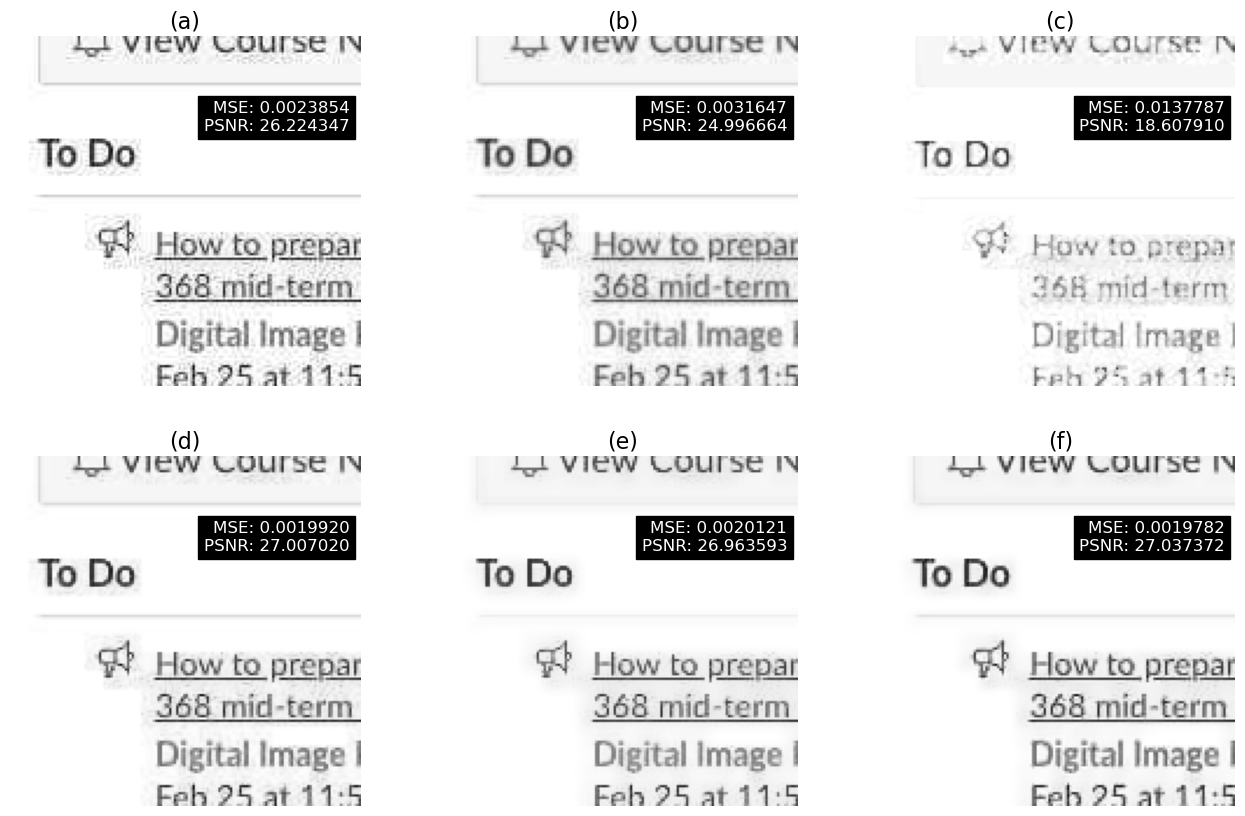

In [ ]:
patch_size = 150
x_start, y_start = 220, 320
show_index = slice(x_start, x_start + patch_size), slice(y_start, y_start + patch_size)
titles = ['Noisy Image',
          f'Gaussian Filter\n(sigma={gaussian_filter_size})',
          f'Median Filter\n(size={median_filter_size})',
          f'Normal Bilateral Filter\n(sigma_r={bilateral_sigma_r1}, sigma_s={bilateral_sigma_s1})',
          f'Normal Bilateral Filter\n(sigma_r={bilateral_sigma_r2}, sigma_s={bilateral_sigma_s2})',
          f'Ours\n(sigma_r={sigma_r}, sigma_s={sigma_s}, sigma_o={sigma_o})'
          ]

symbols=["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]
images = [noised_gray, denoised_gaussian, denoised_median,
          denoised_bilateral1, denoised_bilateral2, denoised_ours]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for i in range(len(images)):
    image = images[i]
    ax = axes[i // 3, i % 3]
    mse_patch = mse(original_gray[show_index], image[show_index])
    psnr_patch = psnr(original_gray[show_index], image[show_index])
    ax.imshow(image[show_index], cmap='gray', vmin=0, vmax=1)
    ax.set_title(symbols[i], fontsize=16)
    ax.axis('off')
    ax.text(145, 40, f'MSE: {mse_patch:.7f}\nPSNR: {psnr_patch:.6f}', fontsize=12, horizontalalignment='right', backgroundcolor='black', color='white')
    print(titles[i])

plt.show()
